In [8]:
import time
import math
import sympy as sp
import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
from sage.all import *
from sage.stats.distributions.discrete_gaussian_integer import DiscreteGaussianDistributionIntegerSampler
from sage.stats.distributions.discrete_gaussian_polynomial import DiscreteGaussianDistributionPolynomialSampler 

In [30]:
def gaussian_sample(sigma, shape):
    # D = DiscreteGaussianDistributionIntegerSampler(sigma)
    # return np.array([D() for _ in range(np.prod(shape))]).reshape(shape)
    samples = np.random.normal(0, sigma, np.prod(shape))
    round_samples = np.array([int(np.floor(s)) for s in samples])
    return round_samples.reshape(shape)

In [197]:
# Evaluation of polynomial p in point x, where p may have matrix coefficients
def polyeval(p, x):
    part_sum = np.zeros_like(p[0])
    pow_x = np.eye(x.shape[0], dtype = int)
    for coef in p:
        part_sum += pow_x @ coef
        pow_x = pow_x @ x
    return part_sum

In [198]:
# Multiplication of two polynomials p1 and p2, where p1 and p2 may have matrix coefficients
def matpolymul(p1, p2):
    number_coefficients = p1.shape[0]+p2.shape[0]-1
    res = np.array([np.zeros_like(p1[0]) for _ in range(number_coefficients)])
    for i in range(p1.shape[0]):
        for j in range(p2.shape[0]):
            res[i+j] += p1[i] * p2[j]
    return res

In [199]:
#Fake commitment class
class CommitmentScheme():
    def __init__(self, lamb, p, N):
        self.lamb = lamb
        self.p = p
        self.N = N
        
    def gen(self):
        print("Generating commitment key...")
        return self.p, 2*self.p
        
def com_msg(msg, randomness, ck):
    # print("Creating commitment to message:\n " + str(msg) + " with randomness " + str(randomness))
    return np.random.randint(0, 2*ck[0], (4,2))

### Class thar runs and controls the protocol flow

In [200]:
class ProductArgument(object):
    
    #Parameters: security level lambda, prime p and N triples ai, bi, ci 
    #such that ai*bi = ci (flatA = [a1, a2, ..., aN])
    
    lamb = None
    p = None
    flatA = None
    flatB = None
    flatC = None
    
    
    def __init__(self, lamb, p, flatA, flatB, flatC):
        self.lamb = lamb
        self.p = p
        self.flatA = flatA
        self.flatB = flatB
        self.flatC = flatC
        
    
    def run(self):
        assert self.flatA.size == self.flatB.size == self.flatC.size
        N = self.flatA.size
        
        #Generates the commitment scheme for N values in Zp with security
        #lambda. This defines n, k, m, q ... (?)
        cs = CommitmentScheme(self.lamb, self.p, N)
        ck = cs.gen()
        
        #TO-DO: Reshape A,B,C into m matrices kxn, according to cs
        
        m = 2  # m = ck[2]
        k = 2  # k = ck[3]
        n = 2  # n = ck[4]
        
        Ai = self.flatA.reshape((m, k, n))
        Bi = self.flatB.reshape((m, k, n))
        Ci = self.flatC.reshape((m, k, n))
        
        #Create prover
        prover = ProductArgumentProver(self.lamb, self.p, Ai, Bi, Ci, ck)
        
        #Create verifier
        verifier = ProductArgumentVerifier(self.lamb, self.p, m, k, n, ck)
        
        #Start protocol
        start_time = time.time()
        
        bfA0, bfAi, bfBi, bfBmm1, bfCi = prover.commit_witness()
        
        bfy = verifier.generate_challenge()
        
        print("\nThe verifier sends the challenge y = " + str(bfy))
        
        bfHl = prover.compute_and_commit_polynomials(bfy)
        
        bfx = verifier.generate_challenge()
        
        print("\nThe verifier sends the challenge x = " + str(bfx))
        
        prover.evaluate_polynomials(bfy, bfx)
        
        bfD, bfE = prover.modulus_correction(bfy, bfx)
        
        bfz = verifier.generate_challenge()
        
        print("\nThe verifier sends the challenge z = " + str(bfz))
        
        A, alpha, B, beta, rho, barD, bardelta = prover.rejections(bfy, bfx, bfz)
        
        bit = verifier.verify(bfA0, bfAi, bfBi, bfBmm1, bfCi, bfHl, bfD, bfE,
              A, alpha, B, beta, rho, barD, bardelta, bfy, bfx, bfz)
        
        return bit
    
    

In [256]:
class ProductArgumentProver(object):
    lamb = None
    ck = None
    Ai = None
    Bi = None
    Ci = None
    k = None
    m = None
    n = None
    N = None
    p = None
    q = None
    np = None
    sigma1 = None
    sigma2 = None
    sigma3 = None
    sigma4 = None
    
    
    def __init__(self, lamb, p, Ai, Bi, Ci, ck):
        
        assert Ai.shape == Bi.shape == Ci.shape
        
        self.Ai = Ai
        self.Bi = Bi
        self.Ci = Ci
        self.m = Ai.shape[0]
        self.k = Ai.shape[1]
        self.n = Ai.shape[2]
        
        print("Ai = " + str(Ai))
        print("\nBi = " + str(Bi))
        print("\nCi = " + str(Ci))
        
        self.ck = ck
        self.p = ck[0]
        self.q = ck[1]
        self.nprime = 2  # self.nprime = int(2*ck[2]*math.log(ck[1], ck[0]))
        
        self.sigma1 = 48*math.sqrt(self.k*self.n)*self.k*self.m*self.p**2
        self.sigma2 = 72*math.sqrt(2*self.k*self.n)*self.k*self.m*self.p
        self.sigma3 = 24*math.sqrt(2*self.k*self.n)*self.k*self.p*(1+6*self.k*self.m*self.p)
        self.sigma4 = 24*math.sqrt(2)*self.k**2*self.p*self.n*self.sigma2
        
        print("\nsigma1 = " + str(self.sigma1))
        print("\nsigma2 = " + str(self.sigma2))
        print("\nsigma3 = " + str(self.sigma3))
        print("\nsigma4 = " + str(self.sigma4))
    
    def commit_witness(self):
        self.Aizeros = np.array([np.vstack((self.Ai[i], np.zeros_like(self.Ai[i]))) for i in range(self.m)])
        self.Bizeros = np.array([np.vstack((self.Bi[i], np.zeros_like(self.Bi[i]))) for i in range(self.m)])
        self.CiCpi = self.Aizeros * self.Bizeros % self.p
        #This should be done in a suitable basis of GF(p^{2k}) (???)
        
        print("\nAizeros = " + str(self.Aizeros))
        print("\nBizeros = " + str(self.Bizeros))
        print("\nCiCpi = " + str(self.CiCpi))
        
        
        self.A0 = gaussian_sample(self.sigma1, (2*self.k, self.n))
        self.Bmm1 = gaussian_sample(self.sigma1, (2*self.k, self.n))
        
        self.alphai = np.random.randint(0, self.p, [self.m, self.k, self.nprime])
        self.betai = np.random.randint(0, self.p, [self.m, self.k, self.nprime])
        self.gammai = np.random.randint(0, self.p, [self.m, 2*self.k, self.nprime])
        
        self.alphaizeros = np.array([np.vstack((self.alphai[i], np.zeros_like(self.alphai[i]))) for i in range(self.m)])
        self.betaizeros = np.array([np.vstack((self.betai[i], np.zeros_like(self.betai[i]))) for i in range(self.m)])
        

        self.alpha0 = gaussian_sample(self.sigma1, (2*self.k, self.nprime))
        self.betamm1 = gaussian_sample(self.sigma1, (2*self.k, self.nprime))
        
        # self.bfAi = com_msg(self.Aizeros, self.alphaizeros, self.ck)
        self.bfAi = np.array([com_msg(self.Aizeros[i], self.alphaizeros[i], self.ck) for i in range(self.m)])
        self.bfBi = np.array([com_msg(self.Bizeros[i], self.betaizeros[i], self.ck) for i in range(self.m)])
        self.bfCi = np.array([com_msg(self.CiCpi[i], self.gammai[i], self.ck) for i in range(self.m)])
                             
        print("\nbfAi = " + str(self.bfAi))
        print("\nbfBi = " + str(self.bfBi))
        print("\nbfCi = " + str(self.bfCi))
        
        self.bfA0 = com_msg(self.A0, self.alpha0, self.ck)
        self.bfBmm1 = com_msg(self.Bmm1, self.betamm1, self.ck)
        
        print("\nbfA0 = " + str(self.bfA0))
        print("\nbfBmm1 = " + str(self.bfBmm1))
        
        return self.bfA0, self.bfAi, self.bfBi, self.bfBmm1, self.bfCi  
        
        
    def compute_and_commit_polynomials(self, bfy):
        Mbfy = np.diag(bfy) #Matrix that emulates left product by bfy in GF(p^{2k}) (???)
        #Compute polynomial A(X) = A0 + Aizeros[0]*y*X + Aizeros[1]*y²*X² + ... + Aizeros[m-1]*y^m*X^
    
        self.AX =  np.array([self.A0 if i == 0 else (Mbfy**i % self.p) @ self.Aizeros[i-1] for i in range(self.m + 1)])
        print("\nA0 = " + str(self.A0))
        print("\nA(X) = " + str(self.AX))
           
        #Compute polynomial B(X) = B_(m+1) + Bizeros[m-1]*X + Bizeros[m-2]*X² + ... + Bizeros[0]*X^m
        self.BX = np.append([self.Bmm1], np.flip(self.Bizeros, 0), axis = 0)    
        print("\nB(X) = " + str(self.BX))    
          
        #Calculate value of C = CiCpi[0]*y + CiCpi[1]*y² + CiCpi[2]*y³ + ... + CiCpi[m-1]*y^m
        self.C = np.sum(np.array([Mbfy**(i+1) @ self.CiCpi[i] for i in range(self.m)]), axis = 0) % self.p #polyeval is in Utilities.ipynb
        print("\nC = " + str(self.C))
        
        print(self.AX.shape, self.BX.shape)
        self.Hl = matpolymul(self.AX, self.BX) % self.p #The (m+1) coefficient of Hl is C
        print("\nHl = " + str(self.Hl))
        
        # Commit to polynomials
        self.etal = np.random.randint(0, self.p, [2*self.m, 2*self.k, self.nprime])
        print("\netal = " + str(self.etal))
        
        self.bfHl = np.array([com_msg(self.Hl[l], self.etal[l], self.ck) for l in range(2*self.m)])
        
        self.bfHl[self.m+1] = np.zeros_like(self.bfHl[0]) # (m+1) coeff is zero
        print("\nbfHl = " + str(self.bfHl))
        
        return self.bfHl
    
    
    def evaluate_polynomials(self, bfx, bfy):
        Mbfx = np.diag(bfx) #Matrix that emulates left product by bfx in GF(p^{2k}) (???)
        Mbfy = np.diag(bfy) #Matrix that emulates left product by bfy in GF(p^{2k}) (???)
        powered_Mbfy = Mbfy #On iteration i this will be Mbfy to the (i+1)-th power
        powered_Mbfx = Mbfx
        
        self.A = self.A0
        self.alpha = self.alpha0
        self.B = self.Bmm1
        self.beta = self.betamm1   
        #Calculate value A = A0 + Aizeros[0]*y*x + Aizeros[1]*y²*x² + ... + Aizeros[m-1]*y^m*x^m
        # and alpha = alpha0 + ...
        for i in range(self.m):
            Mxy = (powered_Mbfx @ powered_Mbfy) % self.p
            self.A += Mxy @ self.Aizeros[i]
            self.alpha += Mxy @ self.alphaizeros[i]
            self.B += (powered_Mbfx % self.p) @ self.Bizeros[self.m-i-1]
            self.beta += (powered_Mbfx % self.p) @ self.betaizeros[self.m-i-1]
            powered_Mbfy = powered_Mbfy @ Mbfy
            powered_Mbfx = powered_Mbfx @ Mbfx
        
        # self.A = self.A % self.p
        # self.B = self.B % self.p
        print("\nA = " + str(self.A))
        print("\nB = " + str(self.B))
        
        
        self.Ax = polyeval(self.AX, Mbfx) % self.p
        self.Bx = polyeval(self.BX, Mbfx) % self.p
        
        print("\nA(x) = " + str(self.Ax))
        print("\nB(x) = " + str(self.Bx))
        
        #Check: A(x) = A mod p, B(x) = B mod p
        assert (self.Ax % self.p == self.A % self.p).all
        assert (self.Bx % self.p == self.B % self.p).all
        
            
        
    def modulus_correction(self, bfy, bfx):
        Mbfy = np.diag(bfy)
        Mbfx = np.diag(bfx)
        self.D = (self.A * self.B) % self.p - polyeval(self.CiCpi, (Mbfy % self.p))\
            - polyeval(self.Hl, (Mbfx % self.p)) + (Mbfx % self.p)**(self.m + 1) @ self.Hl[self.m]

        self.delta = gaussian_sample(self.sigma2, (2*self.k, self.nprime))
        self.bfD = com_msg(self.D, self.delta, self.ck)
        self.E = self.p * gaussian_sample(self.sigma3, (2*self.k, self.n))
        self.epsilon = gaussian_sample(self.sigma4, (2*self.k, self.nprime))
        self.bfE = com_msg(self.E, self.epsilon, self.ck)

        print("\nD = " + str(self.D))
        print("\nE = " + str(self.E))

        assert (self.E % self.p == 0).all
        
        return self.bfD, self.bfE
        
    
    def rejections(self, bfy, bfx, bfz):
        Mbfy = np.diag(bfy)
        Mbfx = np.diag(bfx)
        Mbfz = np.diag(bfz)
        
        M1 = np.hstack((self.A, self.alpha, self.B, self.beta))
        print("\nAalphaBbeta = " + str(M1))
        M2 = np.hstack((self.A0, self.alpha0, self.Bmm1, self.betamm1))
        print("\nA0alpha0B0beta0 = " + str(M2))
        # Rej(M1, M1 - M2, self.sigma1, self.e) # What is e?? Pass all rejections with probability 1/e⁴
        
        # Calculate rho
        # First summand
        self.rho = 0
        for i in range(self.m):
            self.rho += (Mbfx**(self.m+1) @ Mbfy**i % self.p) @ self.gammai[i] #  The m+1 might be m+1-i
            
        # Second summand
        self.rho += polyeval(self.etal, (Mbfx % self.p)) - (Mbfx % self.p)**(self.m + 1) @ self.etal[self.m]
        # Third summand
        self.rho += self.delta
        
        print("\nrho = " + str(self.rho))
        # Rej(self.rho, self.rho - self.delta, self.sigma2, self.e)
        
        self.barD = (Mbfz % self.p) @ self.D + self.E
        self.bardelta = (Mbfz % self.p) @ self.delta + self.epsilon
        
        print("\nbarD = " + str(self.barD))
        print("\nbardelta = " + str(self.bardelta))
        # Rej(self.barD / self.p, self.D/self.p, self.sigma3, self.e)
        # Rej(self.bardelta, self.delta, self.sigma4, self.e)
        
        return self.A, self.alpha, self.B, self.beta, self.rho, self.barD, self.bardelta
    

In [257]:
class ProductArgumentVerifier(object):
    lamb = None
    ck = None
    calB = None
    k = None
    m = None
    n = None
    N = None
    p = None
    q = None
    np = None
    
    def __init__(self, lamb, p, m, k, n, ck):
        
        self.lamb = lamb
        self.p = p
        self.m = m
        self.k = k
        self.n = n
        self.ck = ck
        
        self.sigma1 = 48*math.sqrt(self.k*self.n)*self.k*self.m*self.p**2
        self.sigma2 = 72*math.sqrt(2*self.k*self.n)*self.k*self.m*self.p
        self.sigma3 = 24*math.sqrt(2*self.k*self.n)*self.k*self.p*(1+6*self.k*self.m*self.p)
        self.sigma4 = 24*math.sqrt(2)*self.k**2*self.p*self.n*self.sigma2
    
    
    # Generate challenges bfy, bfx and bfz 
    def generate_challenge(self):
        c = np.random.randint(0, self.p, 2*self.k)
        return c
    
    def verify(self, bfA0, bfAi, bfBi, bfBmm1, bfCi, bfHl, bfD, bfE,
              A, alpha, B, beta, rho, barD, bardelta, bfy, bfx, bfz):
        
        Mbfy = np.diag(bfy)
        Mbfx = np.diag(bfx)
        Mbfz = np.diag(bfz)
        
        # Gather bfA0 and bfAi
        bfA = np.array([bfA0 if i == 0 else bfAi[i-1] for i in range(bfAi.shape[0]+1)])
        
        eq1 = com_msg(A, alpha, self.ck) == polyeval(bfA, (Mbfx@Mbfy % self.p))
        eq1 = eq1.all()
        
        print("Equation 1: " + str(eq1))
        
        # Gather bfBi and bfBmm1
        bfB = np.array([bfBmm1 if i == self.m else bfBi[i] for i in range(bfBi.shape[0]+1)]) 
        
        eq2 = com_msg(B, beta, self.ck) == polyeval(np.flip(bfB, 0), (Mbfx % self.p))
        eq2 = eq2.all()
        
        print("Equation 2: " + str(eq2))
        
        # Calculate rhs of 3rd equation 
        rhs = 0
        for i in range(self.m):
            rhs += (Mbfx**(self.m+1) @ Mbfy**i % self.p) @ bfCi[i] #  The m+1 might be m+1-i
            
        rhs += polyeval(bfHl, (Mbfx % self.p)) - (Mbfx % self.p)**(self.m + 1) @ bfHl[self.m]
        
        rhs += bfD
        
        eq3 = com_msg((A*B) % self.p, rho, self.ck) == rhs
        eq3 = eq3.all()
        
        print("Equation 3: " + str(eq3))
        
        eq4 = com_msg(barD, bardelta, self.ck) == (Mbfz @ bfD) % self.p + bfE
        eq4 = eq4.all()
        
        print("Equation 4: " + str(eq4))
        
        eq5 = barD % self.p == 0
        eq5 = eq5.all()
        
        print("Equation 5: " + str(eq5))
        
        eq6 = np.linalg.norm(barD) <= 2*math.sqrt(self.k*self.n)*self.sigma3*self.p
        
        print("Equation 6: " + str(eq6))
        
        eq7 = np.linalg.norm(np.hstack((A, alpha, B, beta)))\
                             <= 4*math.sqrt(self.k*self.n)*self.sigma1
                             
        print("Equation 7: " + str(eq7))    
            
        eq8 = np.linalg.norm(rho) <= 2*math.sqrt(self.k*self.n)*self.sigma2
                             
        print("Equation 8: " + str(eq8))    
            
        eq9 = np.linalg.norm(bardelta) <= 2*math.sqrt(self.k*self.n)*self.sigma4
                             
        print("Equation 9: " + str(eq9))
        
        return eq1 and eq2 and eq3 and eq4 and eq5 and eq6 and eq7 and eq8 and eq9 
        

In [258]:
def productArgument_test():
    
    lamb = 64
    p = 5
    N = 8
    
    flatA = np.random.randint(0, p, size = N)
    flatB = np.random.randint(0, p, size = N)
    flatC = flatA * flatB % p # Hadamard product
    
    print(flatA)
    print(flatB)
    print(flatC)
    
    argument = ProductArgument(lamb, p, flatA, flatB, flatC)
    argument.run()
    
productArgument_test()

[3 0 3 4 0 1 0 2]
[4 3 0 4 3 1 3 3]
[2 0 0 1 0 1 0 1]
Generating commitment key...
Ai = [[[3 0]
  [3 4]]

 [[0 1]
  [0 2]]]

Bi = [[[4 3]
  [0 4]]

 [[3 1]
  [3 3]]]

Ci = [[[2 0]
  [0 1]]

 [[0 1]
  [0 1]]]

sigma1 = 9600.0

sigma2 = 4072.9350596345143

sigma3 = 82137.52370262936

sigma4 = 5529600.000000001

Aizeros = [[[3 0]
  [3 4]
  [0 0]
  [0 0]]

 [[0 1]
  [0 2]
  [0 0]
  [0 0]]]

Bizeros = [[[4 3]
  [0 4]
  [0 0]
  [0 0]]

 [[3 1]
  [3 3]
  [0 0]
  [0 0]]]

CiCpi = [[[2 0]
  [0 1]
  [0 0]
  [0 0]]

 [[0 1]
  [0 1]
  [0 0]
  [0 0]]]

bfAi = [[[4 9]
  [8 9]
  [5 7]
  [8 5]]

 [[4 3]
  [8 2]
  [4 7]
  [8 6]]]

bfBi = [[[1 8]
  [3 7]
  [7 7]
  [8 6]]

 [[7 5]
  [3 9]
  [6 7]
  [2 5]]]

bfCi = [[[7 7]
  [5 0]
  [0 9]
  [4 1]]

 [[0 3]
  [1 5]
  [6 0]
  [4 2]]]

bfA0 = [[7 6]
 [8 6]
 [3 8]
 [9 9]]

bfBmm1 = [[6 7]
 [2 0]
 [1 6]
 [9 4]]

The verifier sends the challenge y = [1 1 0 0]

A0 = [[  1091 -12175]
 [ -6002   4741]
 [  2621    372]
 [ -4896  -1644]]

A(X) = [[[  1091 -12175]
  

In [ ]:
p = 7
n = 2
k = 2
m = 2
    
Ai = np.random.randint(0, p, size = [m, k, n])

In [9]:
A = np.random.randint(1, 5, [5,10])
x = np.random.randint(1, 5, 10)
A, x, A@x

(array([[2, 2, 1, 3, 1, 1, 1, 3, 1, 1],
        [2, 4, 1, 1, 2, 1, 2, 1, 2, 3],
        [1, 2, 3, 1, 2, 2, 1, 3, 4, 3],
        [1, 3, 4, 4, 3, 4, 1, 1, 1, 3],
        [3, 3, 3, 2, 1, 3, 4, 2, 4, 4]]),
 array([1, 2, 4, 1, 1, 2, 4, 2, 1, 2]),
 array([29, 37, 44, 51, 62]))

In [10]:
bfy = np.random.randint(1, 5, 10)
np.diag(bfy)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 4]])

In [11]:
np.append(1, 2)

array([1, 2])

In [12]:
A = np.random.randint(1, 5, [ 2, 2])
B = np.random.randint(1, 5, [ 2, 2])
C = np.random.randint(1, 5, [ 2, 2])
A, B, C

(array([[4, 1],
        [1, 4]]), array([[1, 1],
        [1, 1]]), array([[2, 3],
        [2, 4]]))

In [17]:
D = np.diag([1,2,3,4])

array([[ 1,  0,  0,  0],
       [ 0,  4,  0,  0],
       [ 0,  0,  9,  0],
       [ 0,  0,  0, 16]])

In [45]:
for x in range(10)[1::2]:
    print(x)

1
3
5
7
9


In [106]:
matpolymul(np.array([[[1,0],[0,1]], [[2,1],[3,2]]]), np.array([[[-1,4],[1,3]], [[1,0],[0,1]]]))

array([[[-1,  0],
        [ 0,  3]],

       [[-1,  4],
        [ 3,  7]],

       [[ 2,  0],
        [ 0,  2]]])

In [7]:
A = np.array([[[1,0],[0,1]], [[2,1],[3,2]]])
A0 = np.array([[1,0],[0,1]])
B = np.array([A0 if i == 0 else A[i-1] for i in range(A.shape[0]+1)])
C = np.append(A,[A0], axis = 0)
C

array([[[1, 0],
        [0, 1]],

       [[2, 1],
        [3, 2]],

       [[1, 0],
        [0, 1]]])

In [135]:
np.linalg.norm(A0)**2

2.0000000000000004

(array([  2.,  11.,  38., 154., 257., 228., 200.,  79.,  27.,   4.]),
 array([-36. , -29.1, -22.2, -15.3,  -8.4,  -1.5,   5.4,  12.3,  19.2,
         26.1,  33. ]),
 <a list of 10 Patch objects>)

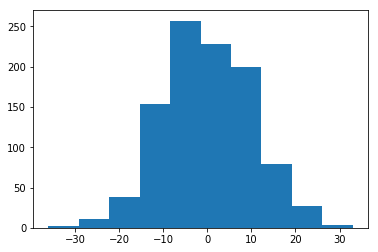

In [29]:
plt.hist(gaussian_sample(10, (1000,)))

(array([  7.,  24.,  84., 157., 234., 252., 154.,  68.,  14.,   6.]),
 array([-32. , -25.6, -19.2, -12.8,  -6.4,   0. ,   6.4,  12.8,  19.2,
         25.6,  32. ]),
 <a list of 10 Patch objects>)

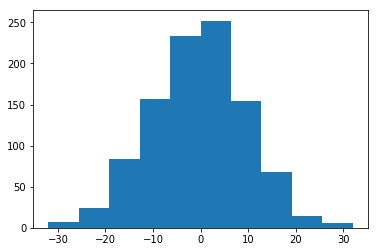

In [31]:
plt.hist(gaussian_sample(10, (1000,)))